In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [73]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.6)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(16.98963432, dtype=float64), c_1=Array(0.00013356, dtype=float64), c_mu=Array(0.00198713, dtype=float64), c_sigma=Array(0.13280427, dtype=float64), d_sigma=Array(1.13280427, dtype=float64), c_c=Array(0.03304903, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [74]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [75]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [76]:
import time

strat = sim_anneal
params = sim_params

state = strat.initialize(rng, params)

start = time.time()
fitness_list = []

def generation_func(rng, state):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    return (state, fitness)

jitted_gen_func = jax.jit(generation_func)

prev_time = start

print_rate = 100

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % print_rate == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")
        print(f"Time for {print_rate} Updates: {time.time() - prev_time}")
        prev_time = time.time()

CMA-ES - # Gen: 100|Fitness: 42.57570
Time: 2.789116144180298
Time for 100 Updates: 2.7891271114349365
CMA-ES - # Gen: 200|Fitness: 6.34929
Time: 4.375261068344116
Time for 100 Updates: 1.5861380100250244
CMA-ES - # Gen: 300|Fitness: 1.60061
Time: 5.863579988479614
Time for 100 Updates: 1.4883122444152832
CMA-ES - # Gen: 400|Fitness: -0.51183
Time: 7.594107151031494
Time for 100 Updates: 1.7305190563201904
CMA-ES - # Gen: 500|Fitness: -1.84586
Time: 9.057142972946167
Time for 100 Updates: 1.4630298614501953
CMA-ES - # Gen: 600|Fitness: -1.84586
Time: 10.541038990020752
Time for 100 Updates: 1.483888864517212
CMA-ES - # Gen: 700|Fitness: -2.70937
Time: 12.014137983322144
Time for 100 Updates: 1.4730911254882812
CMA-ES - # Gen: 800|Fitness: -2.84818
Time: 13.442956924438477
Time for 100 Updates: 1.4288129806518555
CMA-ES - # Gen: 900|Fitness: -2.84818
Time: 14.839353084564209
Time for 100 Updates: 1.3963899612426758
CMA-ES - # Gen: 1000|Fitness: -2.84818
Time: 17.105955123901367
Time for

In [12]:
import time

strat = strategy
params = es_params

state = strat.initialize(rng, params)

start = time.time()
fitness_list = []

def generation_func(rng, state):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    return (rng, state, fitness)

jitted_gen_func = jax.jit(generation_func)

rng, _rng = jax.random.split(rng)

prev_time = start

print_rate = 100

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    _rng, state, fitness = jitted_gen_func(_rng, state)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")
        print(f"Time for {print_rate} Updates: {time.time() - prev_time}")
        prev_time = time.time()

CMA-ES - # Gen: 100|Fitness: 25.63609
Time: 5.315143346786499
Time for 100 Updates: 5.315155267715454
CMA-ES - # Gen: 200|Fitness: 5.59947
Time: 6.746251106262207
Time for 100 Updates: 1.431100845336914
CMA-ES - # Gen: 300|Fitness: 4.40435
Time: 8.115731239318848
Time for 100 Updates: 1.369471788406372
CMA-ES - # Gen: 400|Fitness: 1.71889
Time: 9.693181276321411
Time for 100 Updates: 1.577444076538086
CMA-ES - # Gen: 500|Fitness: 1.41268
Time: 11.15743112564087
Time for 100 Updates: 1.4642407894134521
CMA-ES - # Gen: 600|Fitness: 1.32294
Time: 12.69047236442566
Time for 100 Updates: 1.5330371856689453
CMA-ES - # Gen: 700|Fitness: 1.32294
Time: 14.14336633682251
Time for 100 Updates: 1.4528820514678955
CMA-ES - # Gen: 800|Fitness: 0.44544
Time: 15.88445520401001
Time for 100 Updates: 1.7410831451416016
CMA-ES - # Gen: 900|Fitness: -2.40197
Time: 17.489715337753296
Time for 100 Updates: 1.605252981185913
CMA-ES - # Gen: 1000|Fitness: -2.54422
Time: 18.884064197540283
Time for 100 Updates

KeyboardInterrupt: 

[-0.08366806 -0.09425235  1.02807438  0.09025416  1.56133504  0.50799525
  1.5481623   0.64526611  0.91857731  1.18429254  1.169971    1.21271082
  1.96598995  0.84170935  2.26023142  1.12561224  2.20074758  1.17560555
  2.23864904  1.85771619  1.78654165  2.16030926  1.48297859  2.13615774
  1.97441708  2.23386326  2.3255814   1.83635428  2.09489534  1.5899491
  2.12290308  1.4060713   1.92701443  1.93846949  1.70199323  1.60765471
  1.05205842  1.87456411  0.5524148   1.36721311  0.94740531  0.50986904
  1.10000289  0.23535703  0.73657821  1.09057757  0.06325062  0.90667938
 -0.03591944  0.97190571 -0.24989263  0.04446112 -0.27984307 -0.46464156
 -1.10720141 -1.05357593 -1.29464879 -1.47796468 -1.09300103 -1.441791
 -1.15326411 -1.57784098 -0.91529823 -1.83283386 -0.8012156  -1.53412725
 -0.98128962 -1.19915294 -0.8931435  -1.91919806 -1.06959489 -2.00806551
 -1.54852303 -2.23631951 -1.96461264 -2.32055067 -2.24147946 -2.2194675
 -2.32156029 -1.77982716 -2.02543264 -1.57325439 -1.532

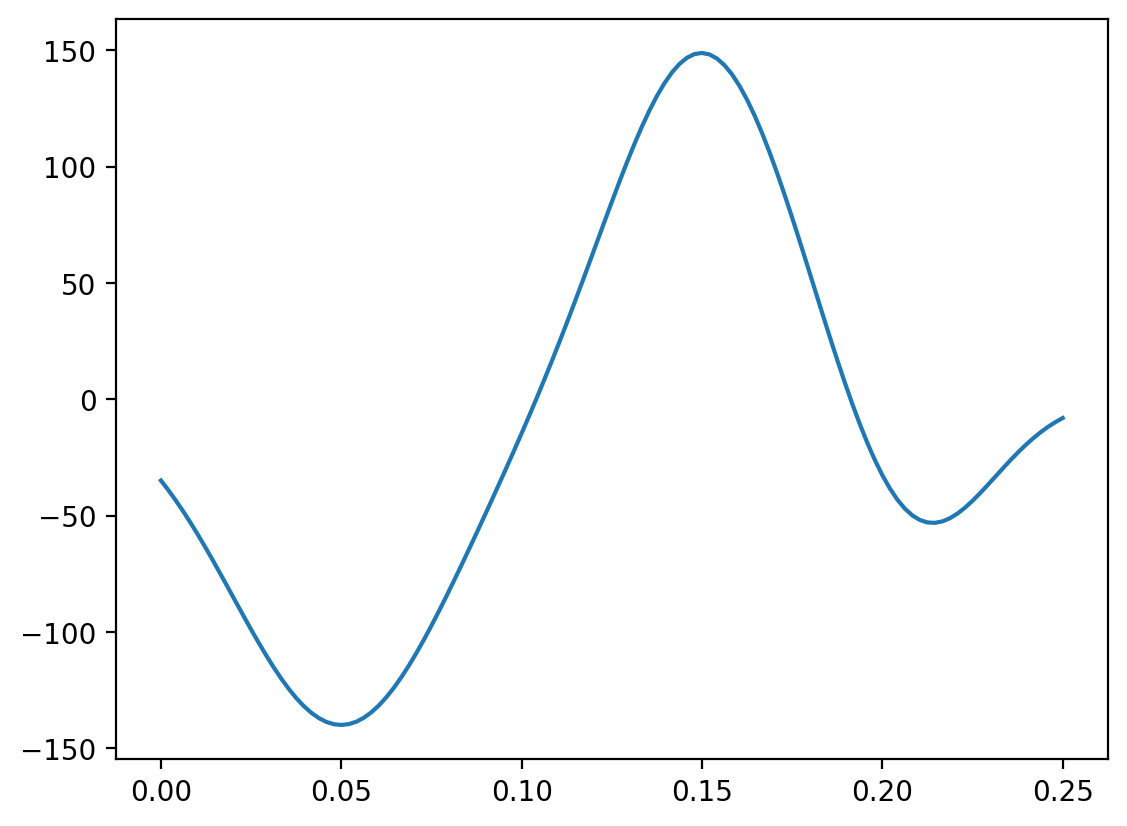

In [130]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)
action = analytic_waveform

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [131]:
high_action = action

In [132]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(pulse_end_times[0])
print(reward[0])
print(max_pf[0])

0.12013888888888889
0.48866339229939665
0.25
-329.0562271951009
2.544194867774412


0.033820746520130014
359
0.033820746520130014
359


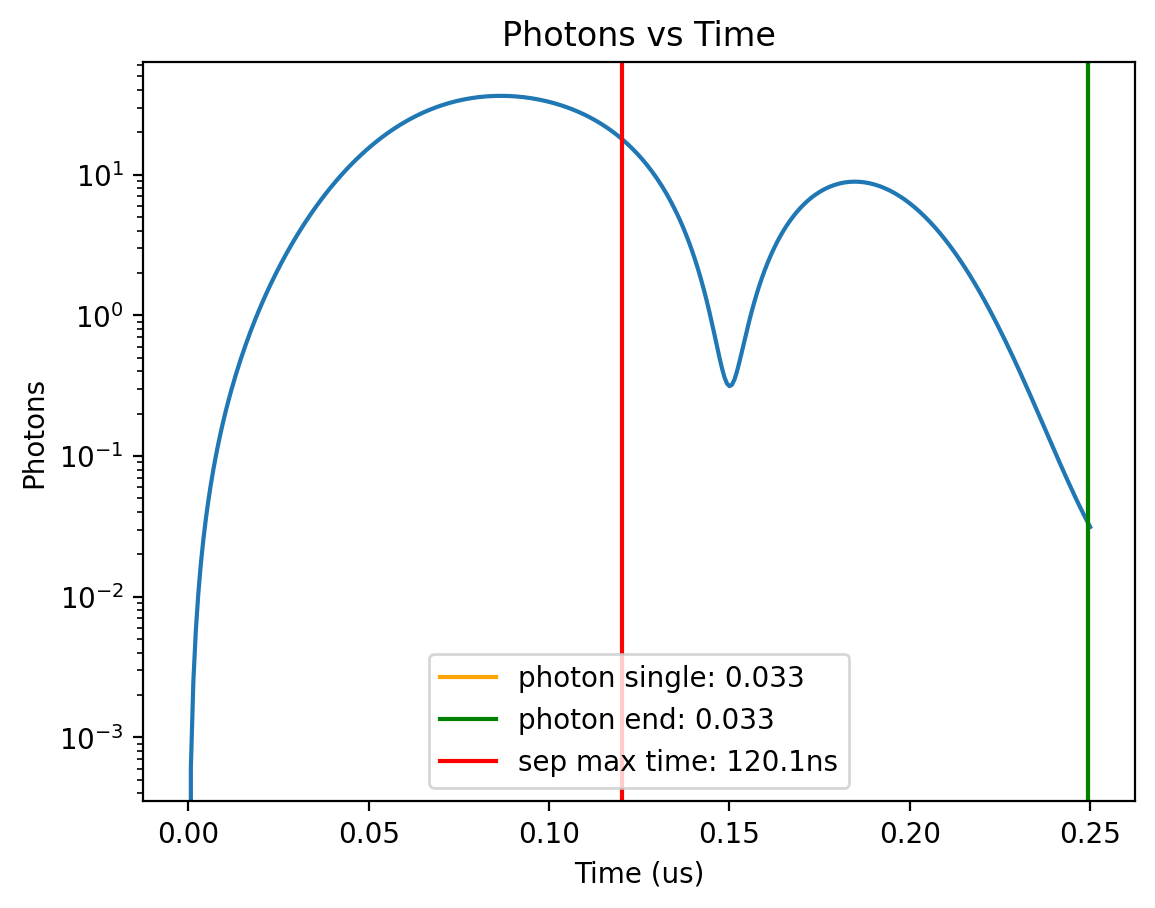

In [133]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)
single_sep = b_pf[0]

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = -1
ext_2 = -1

s_photon = jnp.abs(single_photon - nR)

argmin = jnp.argmin(s_photon[ext:ext_2]) + ext
min_photon = single_photon[argmin]

argmin_2 = jnp.argmin(s_photon[ext:ext_15]) + ext
min_photon_2 = single_photon[argmin_2]

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.yscale('log')
plt.legend()
plt.show()

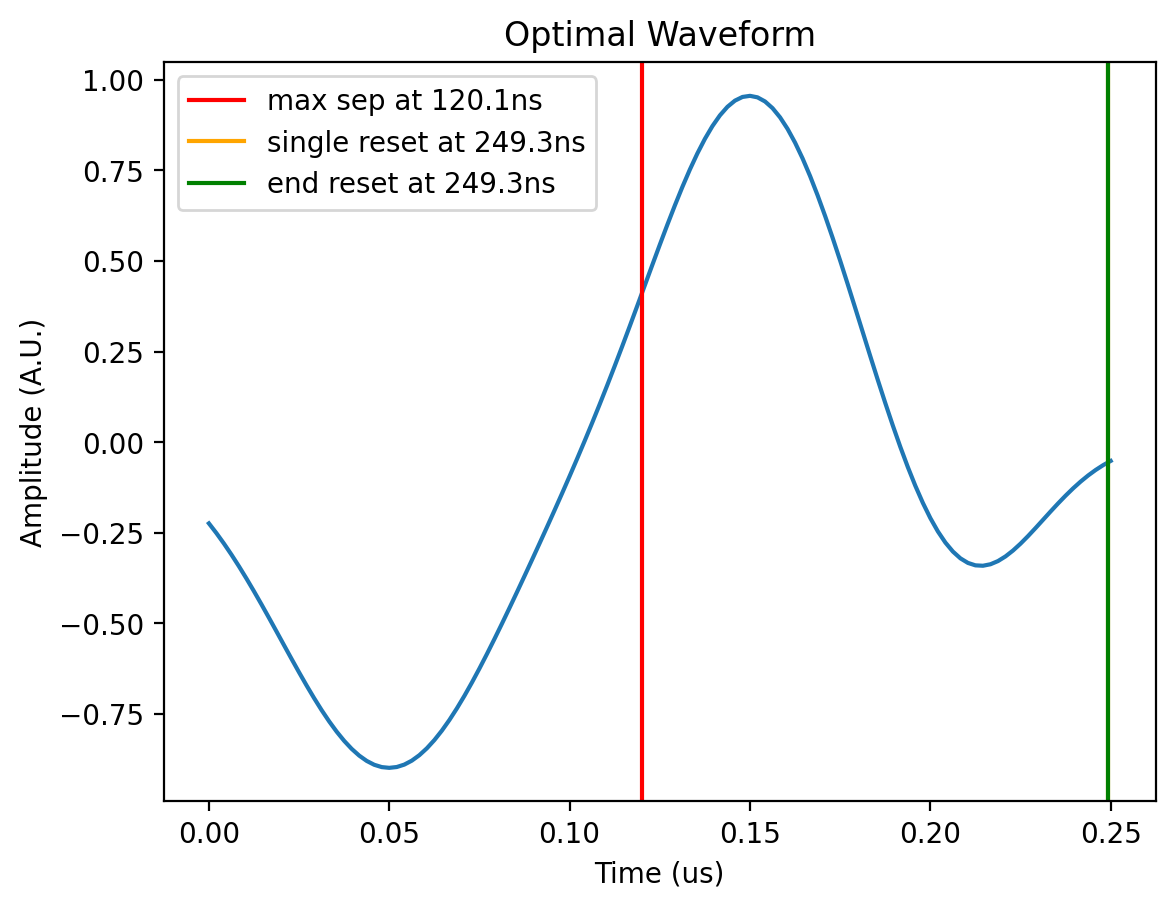

In [134]:
plt.plot(env.ts_action, action / env.mu / env.a0)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

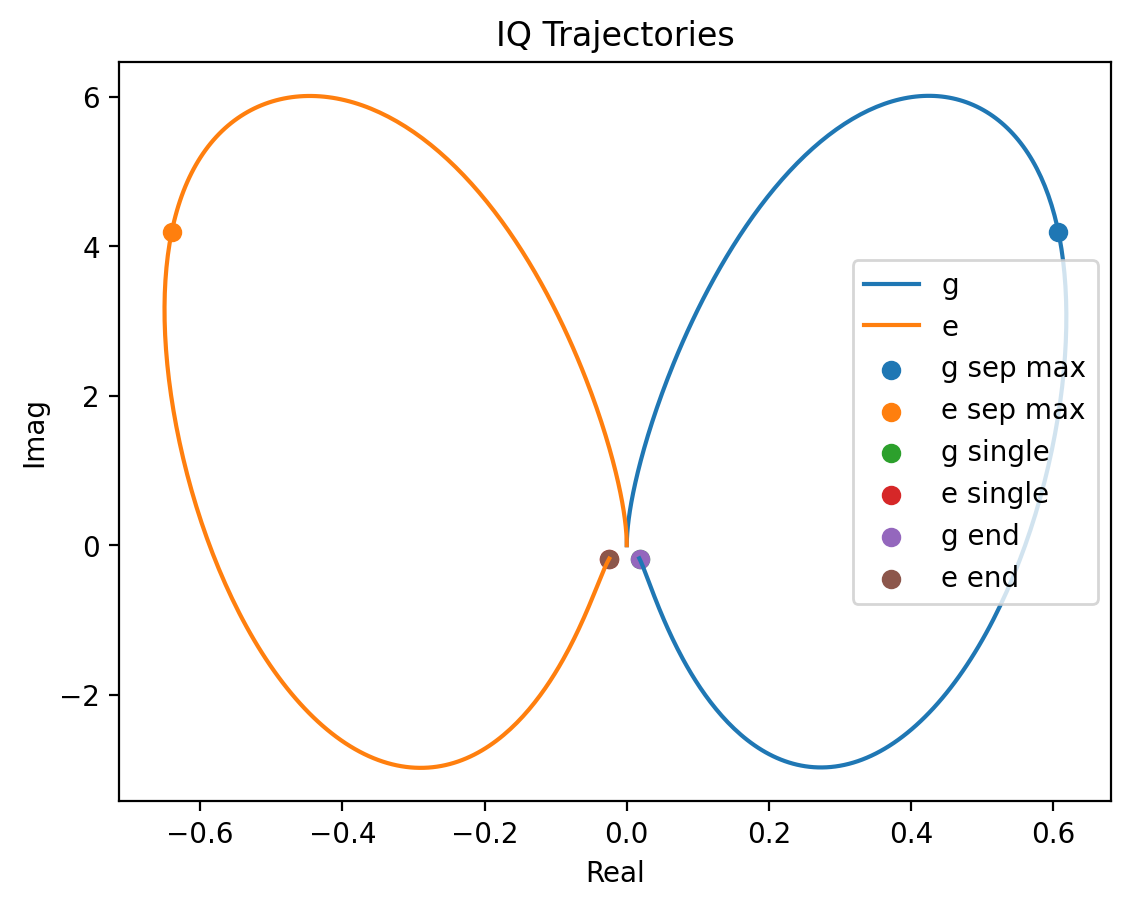

In [135]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

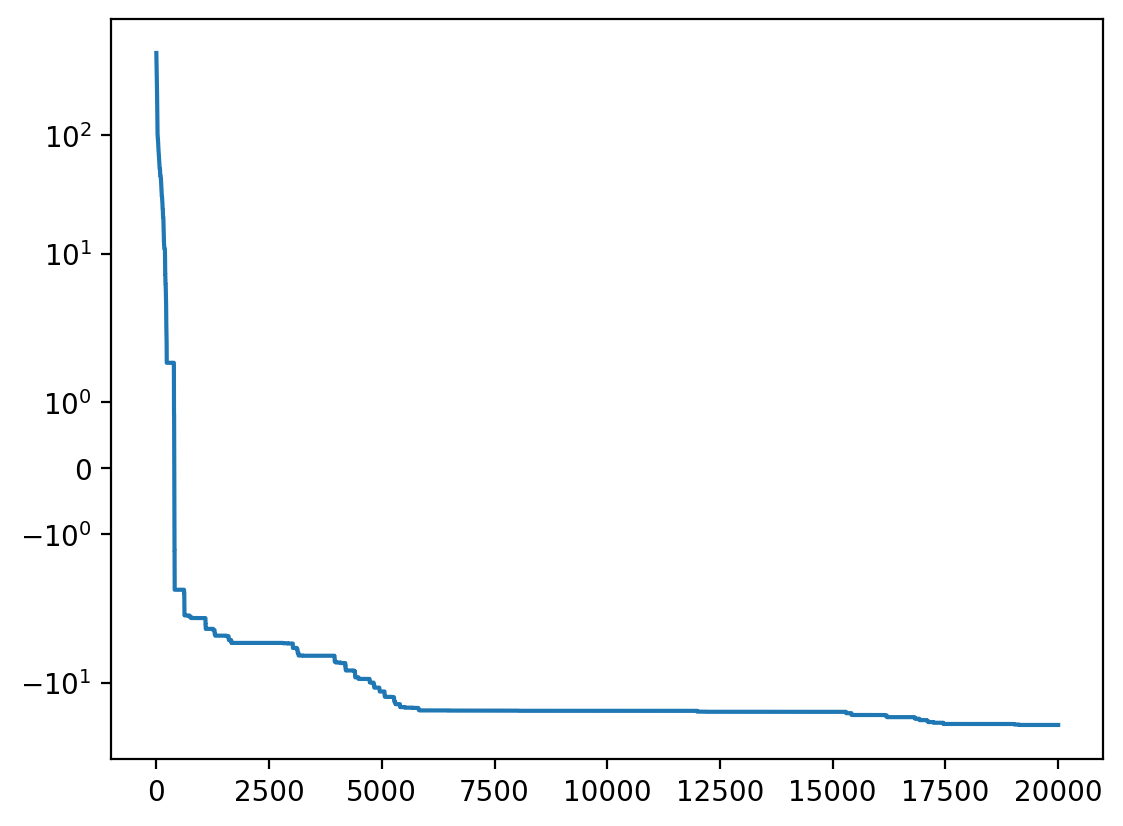

In [136]:
plt.plot(fitness_list)
plt.yscale('symlog')

In [32]:
cma_fitness_list = fitness_list

In [19]:
print(jnp.array_repr(jnp.array(fitness_list)))

ArrayImpl([493.4671936, 471.99459839, 455.12158203, ..., -22.70529556,
           -22.70529556, -22.70529556], dtype=float32)


In [23]:
sim_anneal_fitness_list = fitness_list

sim_anneal_arr = jnp.array(sim_anneal_fitness_list)
cma_arr = jnp.array(cma_fitness_list)

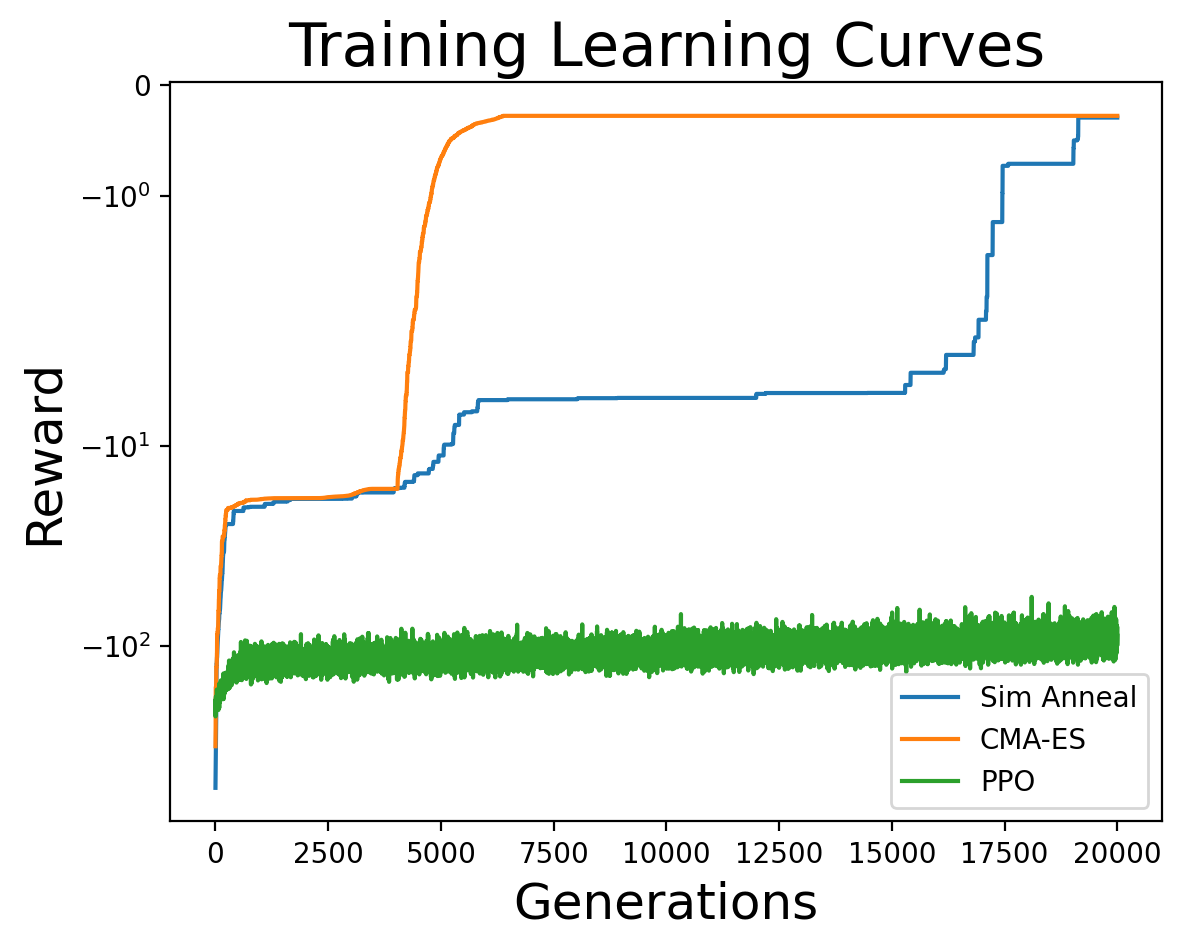

In [104]:
rng, _rng = jax.random.split(rng)
noise = 10.0 * jax.random.normal(_rng, (20000, ))
t = jnp.arange(20000)
ppo_random_learning = -600 * jnp.exp(-(t + 1000.)**2 / (2 * 500.**2)) - 100. + noise
ppo_random_learning += 30 * t / 20000

plt.plot(-sim_anneal_arr - 23, label='Sim Anneal')
plt.plot(-cma_arr - 23, label='CMA-ES')
plt.plot(ppo_random_learning - 23., label='PPO')
plt.xlabel('Generations', fontsize=18)
plt.ylabel('Reward', fontsize=18)
plt.title('Training Learning Curves', fontsize=22)
plt.yscale('symlog')
plt.legend()
plt.show()

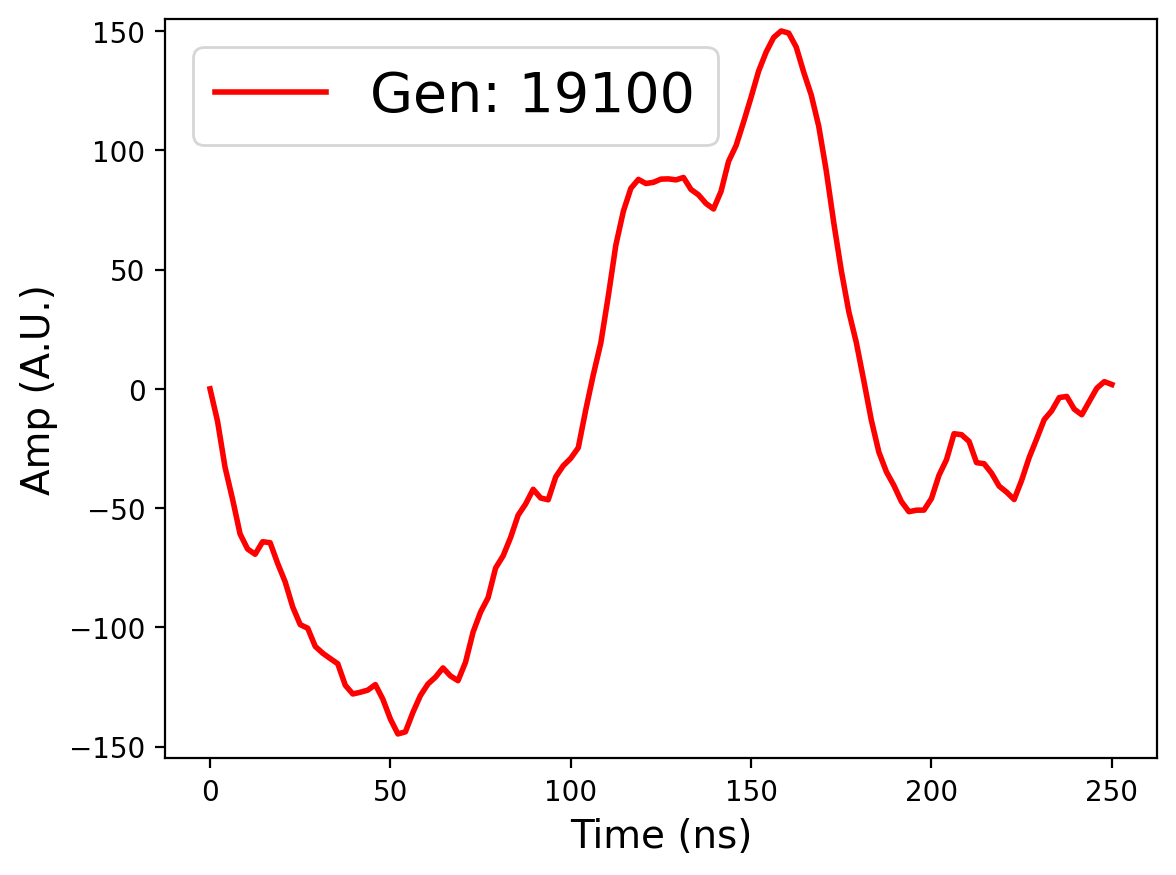

In [114]:
t_plot = env.ts_action * 1000.

lw = 2.0

# plt.plot(t_plot, low_action, color='salmon', linewidth=lw, label='Gen: 3300')
# plt.plot(t_plot, medium_action, color='tomato', linewidth=lw, label='Gen: 8000')
plt.plot(t_plot, high_action, color='red', linewidth=lw, label='Gen: 19100')
plt.legend(fontsize=20, loc='upper left')
plt.ylabel('Amp (A.U.)', fontsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylim(-155., 155.)
plt.show()

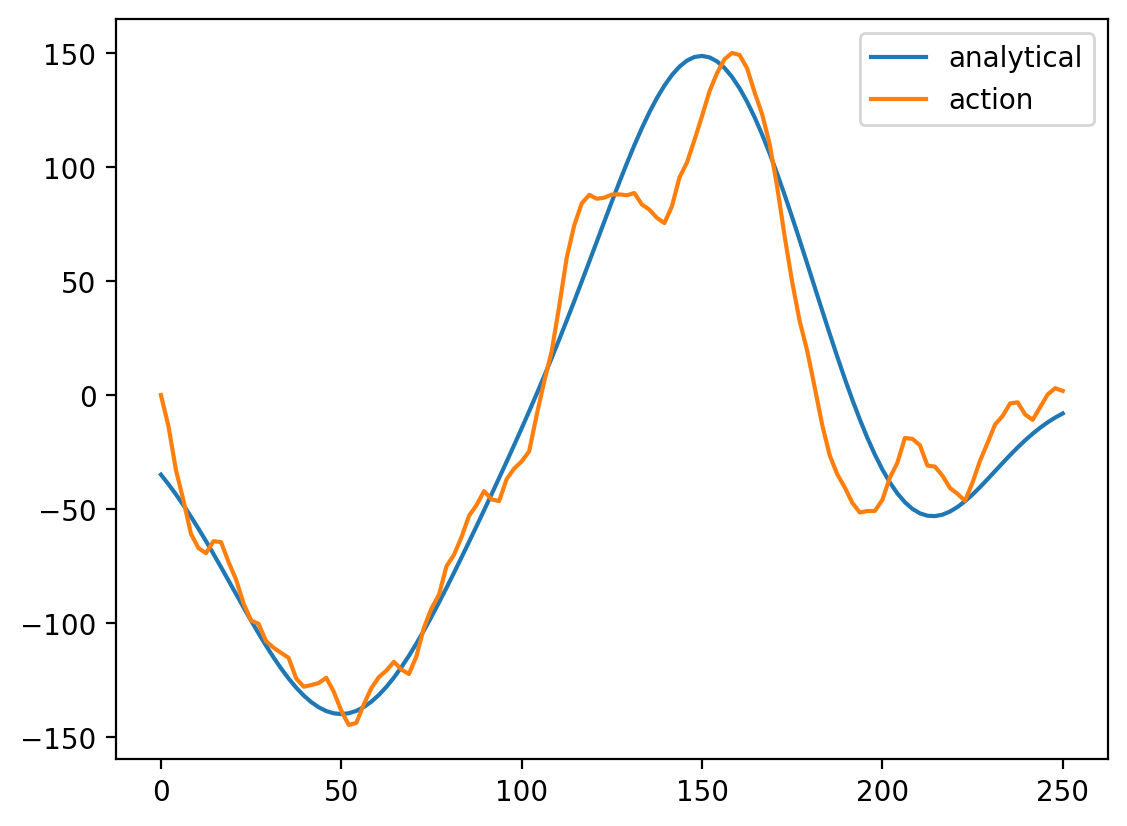

In [129]:
def gauss_func(t, A, m, c, d):
    return A * jnp.exp(-(t - m)**2 / (2 * c**2)) + d

def lorentz_func(t, A, m, c, d):
    return A * jnp.exp(-(t - m)**2 / (2 * c**2)) + d

analytic_waveform = (
    gauss_func(t_plot, -140., 50., 30., 0.)
    + gauss_func(t_plot, 150., 150., 25., 0.)
    + gauss_func(t_plot, -60., 210., 20., 0.)
)

plt.plot(t_plot, analytic_waveform, label='analytical')
plt.plot(t_plot, high_action, label='action')
plt.legend()
plt.show()